#  <b>Language Modeling</b>
<img src="https://quiq.com/wp-content/uploads/2023/10/How-LLM-have-evolved-Feature.png"/>

# 🔴 **Environment Setup**

## 🟠 Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 🟠 Install Required Packages

### 🟡 Install `torchmetrics`

In [ ]:
!pip install -q torchmetrics

### 🟡 Install `torchtext` (stable version)

In [ ]:
!pip install -q torchtext==0.17.0

### 🟡 Install `portalocker`

In [ ]:
!pip install -q portalocker>=2.0.0

# 🔴 **Imports**

In [ ]:
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, IterDataPipe, random_split

from torch import optim
from collections import Counter
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.0+cu121
torchtext --> 0.17.0+cpu
tqdm --> 4.66.6


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 Copy & Unzip Dataset File

In [ ]:
zip_path = '/content/drive/MyDrive/wikitext-2-v1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## 🟠 Load Dataset

In [ ]:
class IterableTextDataPipe(IterDataPipe):

    def __init__(self, file_path):
        self.file_path = file_path

    def __iter__(self):
        with open(self.file_path, encoding='utf-8') as file:
            for line in file:
                yield line.strip()


class WikiTextDataset:
    def __init__(self, train_dir, valid_dir, test_dir):
        self.train = IterableTextDataPipe(train_dir)
        self.valid = IterableTextDataPipe(valid_dir)
        self.test = IterableTextDataPipe(test_dir)

In [ ]:
dataset = WikiTextDataset(train_dir='/content/wikitext-2/wiki.train.tokens',
                          valid_dir='/content/wikitext-2/wiki.valid.tokens',
                          test_dir='/content/wikitext-2/wiki.test.tokens')

train_iter = dataset.train
valid_iter = dataset.valid
test_iter = dataset.test

In [ ]:
train_iter_ = iter(train_iter)

In [ ]:
next(train_iter_)

''

## 🟠 Build Vocabulary

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab(['hi', 'how'])

[9206, 416]

In [ ]:
len(vocab)

28782

In [ ]:
torch.save(vocab, '/content/vocab.pt')

## 🟠 EDA

### 🟡 Mean sentence length

In [ ]:
total_sentence_count = 0
total_sentence_length = 0

for line in train_iter:
    sentences = line.split('.')

    for sentence in sentences:
        tokens = sentence.strip().split()
        sentence_length = len(tokens)

        if sentence_length > 0:
            total_sentence_count += 1
            total_sentence_length += sentence_length

mean_sentence_length = total_sentence_length / total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


### 🟡 The most and the least common words

In [ ]:
freqs = Counter([1, 2, 2, 3, 2, 3])
freqs

Counter({1: 1, 2: 3, 3: 2})

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [ ]:
# The most common
freqs.most_common()

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570),
 ('was', 21008),
 ("'", 18484),
 ('@-@', 16906),
 ('on', 15140),
 ('as', 15058),
 ('s', 14936),
 ('that', 14351),
 ('for', 13794),
 ('with', 13012),
 ('by', 12718),
 (')', 12004),
 ('(', 11992),
 ('@', 11786),
 ('is', 11691),
 ('it', 9273),
 ('from', 9229),
 ('at', 9070),
 ('his', 9019),
 ('he', 8706),
 ('were', 7334),
 ('an', 6250),
 ('had', 5707),
 ('which', 5546),
 ('be', 4859),
 ('are', 4714),
 ('this', 4560),
 ('their', 4290),
 ('first', 4242),
 ('but', 4233),
 ('not', 4006),
 ('–', 3934),
 ('one', 3910),
 ('they', 3894),
 ('its', 3877),
 ('also', 3842),
 ('after', 3749),
 ('her', 3670),
 ('or', 3655),
 ('two', 3565),
 ('have', 3470),
 ('has', 3325),
 ('been', 3263),
 ('who', 3029),
 ('she', 2884),
 ('new', 2767),
 ('other', 2729),
 ('during', 2690),
 ('when', 2655),
 ('time', 2607),
 ('all', 2557),
 ('into', 2443),
 ('m

In [ ]:
# The least common
freqs.most_common()[-6000:]

[('refreshing', 4),
 ('aback', 4),
 ('uproar', 4),
 ('novi', 4),
 ('mshd', 4),
 ('881', 4),
 ('ibrahima', 4),
 ('1726', 4),
 ('mandé', 4),
 ('yalunka', 4),
 ('bundu', 4),
 ('almami', 4),
 ('donnel', 4),
 ('cctv', 4),
 ('fiancée', 4),
 ('fibres', 4),
 ('calmly', 4),
 ('gaviria', 4),
 ('andes', 4),
 ('stylized', 4),
 ('40th', 4),
 ('zurich', 4),
 ('rafa', 4),
 ('jonas', 4),
 ('mcenroe', 4),
 ('tiebreaker', 4),
 ('borg', 4),
 ('racquets', 4),
 ('battled', 4),
 ('tiebreak', 4),
 ('surpass', 4),
 ('prolonging', 4),
 ('baseline', 4),
 ('forehand', 4),
 ('dogfights', 4),
 ('simulators', 4),
 ('graphical', 4),
 ('hantzopoulos', 4),
 ('gauges', 4),
 ('itcz', 4),
 ('accelerating', 4),
 ('mudskippers', 4),
 ('tasting', 4),
 ('bbdo', 4),
 ('squirrels', 4),
 ('mustang', 4),
 ('overlapped', 4),
 ('stella', 4),
 ('mulhall', 4),
 ('windass', 4),
 ('oblivion', 4),
 ('californicus', 4),
 ('diets', 4),
 ('rabbits', 4),
 ('mites', 4),
 ('hares', 4),
 ('sonora', 4),
 ('wheatgrass', 4),
 ('coyote', 4),
 ('l

## 🟠 Transform Data

📌 Reshape the dataset into an `M x L` format, where `M = N x B`.

`N` represents the number of batches, `B` is the batch size, and `L` is the length of a sample within each batch.

In [ ]:
def data_process(raw_text_iter, seq_len):
    data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

    M = len(data) // seq_len
    r = len(data) % seq_len
    data = torch.cat((data, torch.LongTensor([0]))) if r == 0 else data

    inputs = data[:M*seq_len]
    inputs = inputs.reshape(-1, seq_len)

    targets = data[1:M*seq_len+1]
    targets = targets.reshape(-1, seq_len)

    return inputs, targets

In [ ]:
inputs, targets = data_process(train_iter, seq_len=30)
inputs.shape, targets.shape

(torch.Size([68333, 30]), torch.Size([68333, 30]))

In [ ]:
seq_len = 35

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

## 🟠 Custom Dataset

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

## 🟠 Define Dataloader

In [ ]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

# 🔴 **Model**

📌 The model consists of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rnn, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)


  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

In [ ]:
model(x_batch).shape

torch.Size([20, 35, 28782])

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
metric = tm.text.Perplexity().to(device)

In [ ]:
clip = 0.25

# 🔴 **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches


In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(10.2730, device='cuda:0')


### 🟡 **Step 2:** Overfitting the model on a small subset of the dataset (loss → 0)

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:02<00:00, 24.96batch/s, loss=0.252, metric=1.29]


### 🟡 **Step 3:** Training the model for a limited number of epochs, experimenting with various learning rates

In [ ]:
num_epochs = 3

for lr in [3, 1.5, 0.9, 0.3, 0.1]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim=512, num_layers=2,
                        dropout_embd=0.5, dropout_rnn=0.2).to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=3


Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.35batch/s, loss=4.96, metric=142]



LR=1.5


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.57batch/s, loss=5.01, metric=151]



LR=0.9


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.66batch/s, loss=5.21, metric=183]



LR=0.3


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.78batch/s, loss=5.76, metric=318]



LR=0.1


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.73batch/s, loss=6.36, metric=581]

### 🟡 **Step 4:** Create a small grid using the weight decay and the best learning rate





In [ ]:
num_epochs = 1

for lr in [3.]:
  for wd in [1e-6, 1e-5, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=3.0, WD=1e-06


100%|██████████| 2929/2929 [01:53<00:00, 25.88batch/s, loss=5.91, metric=367]



LR=3.0, WD=1e-05


100%|██████████| 2929/2929 [01:54<00:00, 25.65batch/s, loss=5.93, metric=376]



LR=3.0, WD=0.0001


100%|██████████| 2929/2929 [01:54<00:00, 25.67batch/s, loss=6.26, metric=523]

## 🟠 Main Loop

📌 Training the model for longer epochs using the best hyperparameters from **Step 4**

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.5).to(device)

In [ ]:
lr = 3
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:58<00:00, 24.75batch/s, loss=5.92, metric=371]


Model Saved!
Valid: Loss = 5.329, Metric = 206.3



Epoch 2: 100%|██████████| 2929/2929 [01:58<00:00, 24.76batch/s, loss=5.32, metric=203]


Model Saved!
Valid: Loss = 5.152, Metric = 172.9



Epoch 3: 100%|██████████| 2929/2929 [01:58<00:00, 24.71batch/s, loss=5.07, metric=160]


Model Saved!
Valid: Loss = 5.062, Metric = 158.0



Epoch 4: 100%|██████████| 2929/2929 [01:58<00:00, 24.79batch/s, loss=4.92, metric=137]


Model Saved!
Valid: Loss = 5.036, Metric = 153.9



Epoch 5: 100%|██████████| 2929/2929 [01:58<00:00, 24.68batch/s, loss=4.81, metric=123]


Model Saved!
Valid: Loss = 5.005, Metric = 149.1



Epoch 6: 100%|██████████| 2929/2929 [01:58<00:00, 24.72batch/s, loss=4.72, metric=112]


Valid: Loss = 5.009, Metric = 149.7



Epoch 7: 100%|██████████| 2929/2929 [01:58<00:00, 24.80batch/s, loss=4.65, metric=105]


Model Saved!
Valid: Loss = 5.003, Metric = 148.9



Epoch 8: 100%|██████████| 2929/2929 [01:58<00:00, 24.81batch/s, loss=4.6, metric=99.1]


Model Saved!
Valid: Loss = 4.996, Metric = 147.8



Epoch 9: 100%|██████████| 2929/2929 [01:58<00:00, 24.65batch/s, loss=4.55, metric=94.3]


Valid: Loss = 5.006, Metric = 149.4



Epoch 10: 100%|██████████| 2929/2929 [02:00<00:00, 24.39batch/s, loss=4.5, metric=90.3]


Valid: Loss = 5.016, Metric = 150.9



Epoch 11: 100%|██████████| 2929/2929 [02:00<00:00, 24.35batch/s, loss=4.47, metric=87]


Valid: Loss = 5.023, Metric = 151.9



Epoch 12: 100%|██████████| 2929/2929 [01:59<00:00, 24.41batch/s, loss=4.43, metric=84.2]


Valid: Loss = 5.02, Metric = 151.4



Epoch 13:  19%|█▉        | 551/2929 [00:22<01:37, 24.42batch/s, loss=4.31, metric=74.5]


KeyboardInterrupt: 

In [ ]:
! cp /content/model.pt /content/drive/MyDrive/

## 🟠 Plot

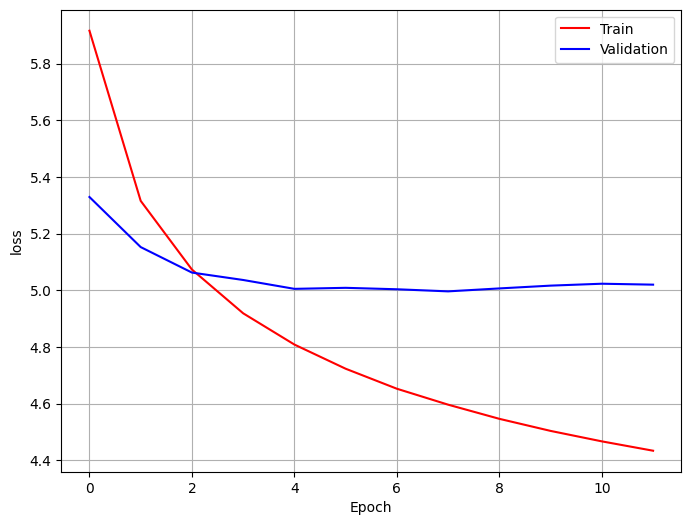

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## 🟠 Improving Model

### 🟡 Experimenting the best model with new learning rates

In [ ]:
num_epochs = 1

for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f'LR={lr}')

  model = torch.load('/content/model.pt')

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=2


100%|██████████| 2929/2929 [01:56<00:00, 25.22batch/s, loss=4.43, metric=83.5]



LR=0.9


100%|██████████| 2929/2929 [01:55<00:00, 25.37batch/s, loss=4.31, metric=74.7]



LR=0.5


100%|██████████| 2929/2929 [01:55<00:00, 25.47batch/s, loss=4.29, metric=73]



LR=0.3


100%|██████████| 2929/2929 [01:54<00:00, 25.51batch/s, loss=4.29, metric=73.2]



LR=0.09


100%|██████████| 2929/2929 [01:53<00:00, 25.79batch/s, loss=4.32, metric=75.5]



LR=0.05


100%|██████████| 2929/2929 [01:54<00:00, 25.57batch/s, loss=4.34, metric=77]

### 🟡 Training the best model for longer epochs

In [ ]:
model = torch.load('/content/model.pt')

In [ ]:
lr = 0.5    # NEW LEARNING RATE
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
num_epochs = 10

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'new-model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:58<00:00, 24.67batch/s, loss=4.29, metric=73.1]


Model Saved!
Valid: Loss = 4.907, Metric = 135.3



Epoch 2: 100%|██████████| 2929/2929 [01:59<00:00, 24.50batch/s, loss=4.2, metric=66.8]


Model Saved!
Valid: Loss = 4.902, Metric = 134.6



Epoch 3: 100%|██████████| 2929/2929 [01:58<00:00, 24.68batch/s, loss=4.15, metric=63.7]


Model Saved!
Valid: Loss = 4.894, Metric = 133.5



Epoch 4: 100%|██████████| 2929/2929 [01:58<00:00, 24.62batch/s, loss=4.11, metric=61.1]


Valid: Loss = 4.901, Metric = 134.5



Epoch 5: 100%|██████████| 2929/2929 [01:58<00:00, 24.67batch/s, loss=4.08, metric=59.1]


Valid: Loss = 4.899, Metric = 134.2



Epoch 6: 100%|██████████| 2929/2929 [01:59<00:00, 24.55batch/s, loss=4.05, metric=57.3]


Valid: Loss = 4.898, Metric = 134.1



Epoch 7: 100%|██████████| 2929/2929 [01:58<00:00, 24.65batch/s, loss=4.02, metric=55.7]


Valid: Loss = 4.907, Metric = 135.2



Epoch 8: 100%|██████████| 2929/2929 [01:58<00:00, 24.67batch/s, loss=3.99, metric=54.2]


Valid: Loss = 4.908, Metric = 135.3



Epoch 9: 100%|██████████| 2929/2929 [01:58<00:00, 24.62batch/s, loss=3.97, metric=52.8]


Valid: Loss = 4.904, Metric = 134.9



Epoch 10: 100%|██████████| 2929/2929 [01:59<00:00, 24.56batch/s, loss=3.94, metric=51.5]


Valid: Loss = 4.912, Metric = 136.0



In [ ]:
! cp '/content/new-model.pt' '/content/drive/MyDrive/'

### 🟡 Plotting learning curves

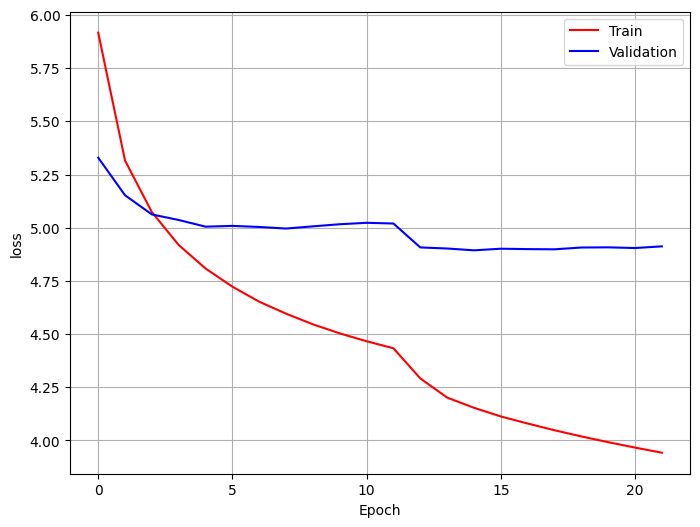

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [ ]:
model_path = '/content/drive/MyDrive/new-model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

125.78819274902344

# 🔴 **Generate**

In [ ]:
model_path = '/content/drive/MyDrive/new-model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # token = itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<unk>']
    while idx == vocab['<unk>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
prompts = ['In a galaxy far, far away, there',
           'The sun was setting in the',
           'Once upon a time, there lived a young princess named']

for i in prompts:
    print(generate(i, 35, 0.5, model, tokenizer, vocab))

In a galaxy far, far away, there are few different names in the genus inocybe , and are now a common name .
The sun was setting in the form of a female , a sequence of the planet , and the other hand .
Once upon a time, there lived a young princess named s house of the church of scientology , and the design became a new one .
